In [54]:
%matplotlib inline
import feather
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [55]:
#Read in mutation frequency trajectories for this replicate, which is actually replicate 0
data=feather.read_dataframe('../H2_0.2_OPT_0.5_mu_0.001.traj.rep1.feather')

In [56]:
#Collect into groups
g=data.groupby([data.esize,data.origin,data.pos])

In [72]:
#Filter groups into new pd.DF based on fixed vs. lost, then re-group
fixations=g.filter(lambda x:x['freq'].max()==1.0 and x['origin'].max() >= 9000 and x['origin'].max() <=15000).groupby(['esize','origin','pos'])
losses=g.filter(lambda x:len(x['freq'])>=5 and x['freq'].max()>=0.1 and x['freq'].max()<1.0).groupby(['esize','origin','pos'])

In [58]:
#Read in the popstats
pstats=feather.read_dataframe('../H2_0.2_OPT_0.5_mu_0.001.popstats.feather')

In [59]:
pstatsRep0=pstats.groupby(['rep']).filter(lambda x:x['rep'].max()==0) #Pull out data for replicate 0.  max() is a hack...

,generation,rep,stat,value
0,1,0,VG,0.000000
1,1,0,VE,0.016191
2,1,0,leading_q,NaN
3,1,0,leading_e,NaN
4,1,0,max_expl,0.000000


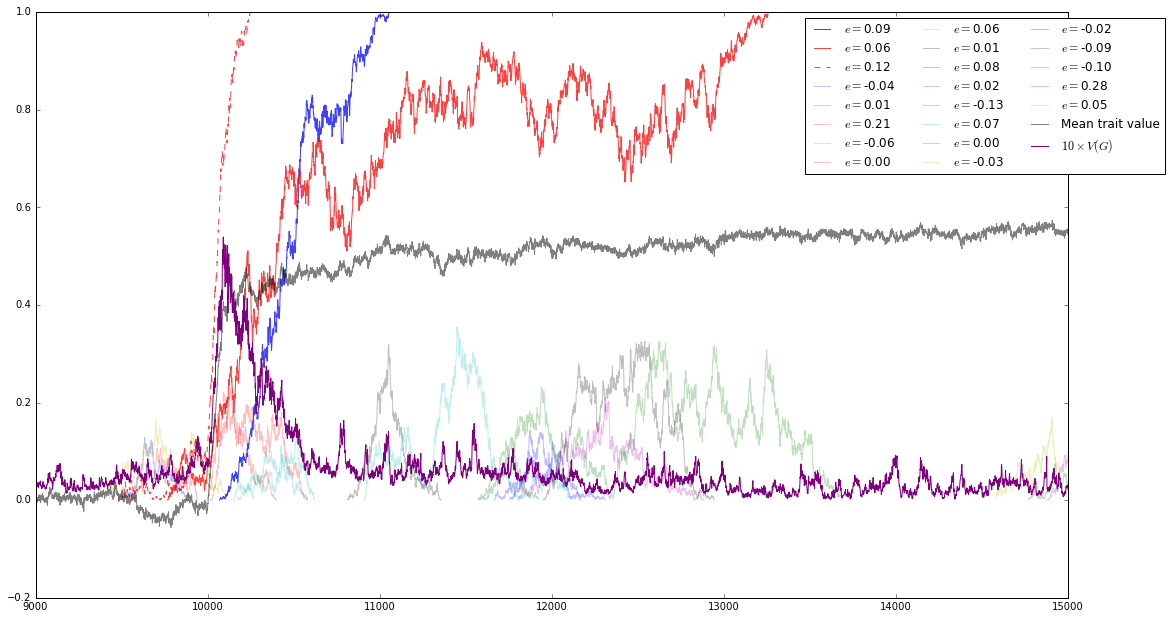

In [110]:
fig= matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
fig.set_size_inches(18.5, 10.5)
plt.plot(dpi=300)
#plot fixations
FSTYLES=['solid','dashed']
FSTYLE=0
for i in fixations.groups:
    fix_i=fixations.get_group(i)
    fix_color="red"
    fix_alpha=0.25
    fix_style=FSTYLES[FSTYLE]
    if fix_i.origin.min()>10000:
        fix_color='blue'
        fix_alpha=1.0
        fix_style='solid'
    else:
        FSTYLE+=1
    esize=fix_i.esize.mean()
    plt.plot(fix_i.generation,fix_i.freq,color=fix_color,
             alpha=0.75,
             linestyle=fix_style,
             label=r'$e = $'+'{0:.2f}'.format(esize))
#Now, deal with losses
for i in losses.groups:
    losses_i=losses.get_group(i)
    if losses_i.origin.max() >= 9000 and losses_i.origin.max() < 15000:
        esize=losses_i.esize.mean()
        plt.plot(losses_i.generation,losses_i.freq,alpha=0.25,label=r'$e = $'+'{0:0.2f}'.format(esize))
        
#PLot mean trait value
plt.plot(pstatsRep0.generation[pstatsRep0.stat=='tbar'],
         pstatsRep0.value[pstatsRep0.stat=='tbar'],
             color='black',alpha=0.5,label="Mean trait value")
#10xVG, so that it shows up
plt.plot(pstatsRep0.generation[pstatsRep0.stat=='tbar'],
         10.0*pstatsRep0.value[pstatsRep0.stat=='VG'],
             color='purple',linestyle='solid',alpha=1,label=r'$10 \times V(G)$')

plt.xlim(9000,15000)
plt.legend(bbox_to_anchor=(1.1,1.0),ncol=3)
plt.savefig("trajectories.pdf",bbox_inches='tight')